# Graph Construction for Weather Station Network

This notebook constructs the graph structure for the GNN weather forecasting model.

## Objectives
1. Load preprocessed data and station metadata
2. Build graph structure (nodes = stations, edges = spatial connections)
3. Implement multiple edge construction strategies (k-NN, distance threshold)
4. Create edge weights based on geographic distance
5. Validate graph connectivity and properties
6. Prepare PyTorch Geometric data objects
7. Save graph structure for model training

## Input
- `data/processed/noaa_isd_preprocessed.parquet` - Preprocessed weather data
- `data/processed/station_metadata.csv` - Station coordinates
- `data/processed/station_distance_matrix.npy` - Pairwise distances

## Output
- `data/graphs/weather_graph_knn.pt` - PyTorch Geometric graph (k-NN)
- `data/graphs/weather_graph_distance.pt` - PyTorch Geometric graph (distance threshold)
- `data/graphs/graph_metadata.json` - Graph construction parameters

In [1]:
# Imports
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Graph libraries
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

# Setup project path
current_dir = Path(os.getcwd()).resolve()
if current_dir.name == '03_graph_construction':
    project_root = current_dir.parent.parent
elif current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    for parent in current_dir.parents:
        if (parent / 'src').exists() and (parent / 'notebooks').exists():
            project_root = parent
            break
    else:
        project_root = current_dir

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.utils.config import PROCESSED_DATA_DIR, GRAPHS_DIR as GRAPH_DATA_DIR

print(f"Project root: {project_root}")
print(f"Processed data directory: {PROCESSED_DATA_DIR}")
print(f"Graph data directory: {GRAPH_DATA_DIR}")

# Create directories
GRAPH_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Check PyTorch/CUDA
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Project root: C:\Users\Kata\Desktop\earth-sgnn
Processed data directory: C:\Users\Kata\Desktop\earth-sgnn\data\processed
Graph data directory: C:\Users\Kata\Desktop\earth-sgnn\data\graphs

PyTorch version: 2.10.0+cpu
CUDA available: False


## 1. Load Preprocessed Data

In [2]:
# Load data
print("Loading preprocessed data...")

# Station metadata
station_meta = pd.read_csv(PROCESSED_DATA_DIR / "station_metadata.csv")
print(f"Stations: {len(station_meta)}")

# Distance matrix
distance_matrix = np.load(PROCESSED_DATA_DIR / "station_distance_matrix.npy")
print(f"Distance matrix shape: {distance_matrix.shape}")

# Preprocessing stats
with open(PROCESSED_DATA_DIR / "preprocessing_stats.json", 'r') as f:
    preprocessing_stats = json.load(f)

# Station ID to index mapping
station_id_to_idx = preprocessing_stats['station_id_to_idx']
idx_to_station_id = {v: k for k, v in station_id_to_idx.items()}

n_stations = len(station_meta)
print(f"\nNumber of nodes (stations): {n_stations}")

Loading preprocessed data...
Stations: 822
Distance matrix shape: (822, 822)

Number of nodes (stations): 822


In [3]:
# Quick stats on distances
print("=" * 60)
print("Distance Statistics")
print("=" * 60)

# Get upper triangle (exclude diagonal)
upper_tri = distance_matrix[np.triu_indices(n_stations, k=1)]

print(f"\nAll pairwise distances (km):")
print(f"  Min: {upper_tri.min():.1f}")
print(f"  Max: {upper_tri.max():.1f}")
print(f"  Mean: {upper_tri.mean():.1f}")
print(f"  Median: {np.median(upper_tri):.1f}")

# Percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
print(f"\nDistance percentiles:")
for p in percentiles:
    val = np.percentile(upper_tri, p)
    print(f"  {p}th: {val:.1f} km")

Distance Statistics

All pairwise distances (km):
  Min: 0.0
  Max: 4243.7
  Mean: 1234.5
  Median: 1083.3

Distance percentiles:
  10th: 320.0 km
  25th: 603.2 km
  50th: 1083.3 km
  75th: 1749.0 km
  90th: 2267.2 km
  95th: 2842.7 km
  99th: 3532.6 km


## 2. Graph Construction Strategies

We implement two common strategies for constructing spatial graphs:

1. **k-Nearest Neighbors (k-NN)**: Connect each station to its k nearest neighbors
2. **Distance Threshold**: Connect stations within a specified distance radius

Both produce weighted edges based on geographic distance.

In [4]:
def build_knn_graph(distance_matrix, k=8, symmetric=True):
    """
    Build k-nearest neighbor graph from distance matrix.
    
    Parameters:
    -----------
    distance_matrix : np.array
        Pairwise distance matrix (n_nodes x n_nodes)
    k : int
        Number of nearest neighbors per node
    symmetric : bool
        If True, make the graph undirected (add reverse edges)
    
    Returns:
    --------
    edge_index : torch.Tensor
        Edge indices (2 x n_edges)
    edge_attr : torch.Tensor
        Edge weights (distances)
    """
    n_nodes = distance_matrix.shape[0]
    
    # Find k nearest neighbors for each node
    edges_src = []
    edges_dst = []
    edge_distances = []
    
    for i in range(n_nodes):
        # Get distances from node i to all others
        distances = distance_matrix[i, :].copy()
        distances[i] = np.inf  # Exclude self-loop
        
        # Find k nearest
        nearest_indices = np.argsort(distances)[:k]
        
        for j in nearest_indices:
            edges_src.append(i)
            edges_dst.append(j)
            edge_distances.append(distances[j])
    
    # Convert to arrays
    edges_src = np.array(edges_src)
    edges_dst = np.array(edges_dst)
    edge_distances = np.array(edge_distances)
    
    if symmetric:
        # Add reverse edges (make undirected)
        edges_src_rev = edges_dst.copy()
        edges_dst_rev = edges_src.copy()
        
        edges_src = np.concatenate([edges_src, edges_src_rev])
        edges_dst = np.concatenate([edges_dst, edges_dst_rev])
        edge_distances = np.concatenate([edge_distances, edge_distances])
        
        # Remove duplicates
        edge_set = set()
        unique_edges_src = []
        unique_edges_dst = []
        unique_distances = []
        
        for s, d, dist in zip(edges_src, edges_dst, edge_distances):
            if (s, d) not in edge_set:
                edge_set.add((s, d))
                unique_edges_src.append(s)
                unique_edges_dst.append(d)
                unique_distances.append(dist)
        
        edges_src = np.array(unique_edges_src)
        edges_dst = np.array(unique_edges_dst)
        edge_distances = np.array(unique_distances)
    
    # Create edge_index tensor
    edge_index = torch.tensor(np.stack([edges_src, edges_dst]), dtype=torch.long)
    edge_attr = torch.tensor(edge_distances, dtype=torch.float32).unsqueeze(1)
    
    return edge_index, edge_attr


def build_distance_threshold_graph(distance_matrix, max_distance=100, min_neighbors=3):
    """
    Build graph connecting stations within a distance threshold.
    
    Parameters:
    -----------
    distance_matrix : np.array
        Pairwise distance matrix (n_nodes x n_nodes)
    max_distance : float
        Maximum distance (km) for edge creation
    min_neighbors : int
        Minimum neighbors to ensure (use k-NN if threshold gives fewer)
    
    Returns:
    --------
    edge_index : torch.Tensor
        Edge indices (2 x n_edges)
    edge_attr : torch.Tensor
        Edge weights (distances)
    """
    n_nodes = distance_matrix.shape[0]
    
    edges_src = []
    edges_dst = []
    edge_distances = []
    
    for i in range(n_nodes):
        distances = distance_matrix[i, :].copy()
        distances[i] = np.inf  # Exclude self-loop
        
        # Find neighbors within threshold
        neighbors = np.where(distances <= max_distance)[0]
        
        # Ensure minimum neighbors
        if len(neighbors) < min_neighbors:
            neighbors = np.argsort(distances)[:min_neighbors]
        
        for j in neighbors:
            edges_src.append(i)
            edges_dst.append(j)
            edge_distances.append(distances[j])
    
    edge_index = torch.tensor(np.stack([edges_src, edges_dst]), dtype=torch.long)
    edge_attr = torch.tensor(edge_distances, dtype=torch.float32).unsqueeze(1)
    
    return edge_index, edge_attr

In [5]:
def compute_edge_weights(edge_attr, method='gaussian', sigma=50):
    """
    Compute edge weights from distances.
    
    Parameters:
    -----------
    edge_attr : torch.Tensor
        Edge distances
    method : str
        'gaussian': exp(-d^2 / (2*sigma^2))
        'inverse': 1 / (d + epsilon)
        'inverse_square': 1 / (d^2 + epsilon)
    sigma : float
        Bandwidth for Gaussian kernel
    
    Returns:
    --------
    weights : torch.Tensor
        Edge weights (higher = stronger connection)
    """
    distances = edge_attr.squeeze()
    
    if method == 'gaussian':
        weights = torch.exp(-distances**2 / (2 * sigma**2))
    elif method == 'inverse':
        weights = 1.0 / (distances + 1.0)
    elif method == 'inverse_square':
        weights = 1.0 / (distances**2 + 1.0)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return weights.unsqueeze(1)

## 3. Build k-NN Graph

In [6]:
# Build k-NN graph with different k values
K_VALUES = [4, 8, 12, 16]

print("=" * 60)
print("Building k-NN Graphs")
print("=" * 60)

knn_graphs = {}

for k in K_VALUES:
    edge_index, edge_attr = build_knn_graph(distance_matrix, k=k)
    
    # Compute edge weights
    edge_weight = compute_edge_weights(edge_attr, method='gaussian', sigma=100)
    
    n_edges = edge_index.shape[1]
    avg_degree = n_edges / n_stations
    
    knn_graphs[k] = {
        'edge_index': edge_index,
        'edge_attr': edge_attr,
        'edge_weight': edge_weight
    }
    
    print(f"\nk={k}:")
    print(f"  Edges: {n_edges}")
    print(f"  Avg degree: {avg_degree:.1f}")
    print(f"  Max edge distance: {edge_attr.max().item():.1f} km")
    print(f"  Mean edge distance: {edge_attr.mean().item():.1f} km")

Building k-NN Graphs

k=4:
  Edges: 4046
  Avg degree: 4.9
  Max edge distance: 993.9 km
  Mean edge distance: 65.1 km

k=8:
  Edges: 7842
  Avg degree: 9.5
  Max edge distance: 1252.3 km
  Mean edge distance: 89.9 km

k=12:
  Edges: 11666
  Avg degree: 14.2
  Max edge distance: 1510.8 km
  Mean edge distance: 110.7 km

k=16:
  Edges: 15446
  Avg degree: 18.8
  Max edge distance: 1764.5 km
  Mean edge distance: 127.0 km


In [7]:
# Check graph connectivity
def check_connectivity(edge_index, n_nodes):
    """Check if graph is connected and return number of components."""
    # Build adjacency matrix
    src = edge_index[0].numpy()
    dst = edge_index[1].numpy()
    data = np.ones(len(src))
    adj = csr_matrix((data, (src, dst)), shape=(n_nodes, n_nodes))
    
    n_components, labels = connected_components(adj, directed=False)
    
    return n_components, labels

print("\nConnectivity Check:")
for k, graph_data in knn_graphs.items():
    n_comp, _ = check_connectivity(graph_data['edge_index'], n_stations)
    status = "✓ Connected" if n_comp == 1 else f"✗ {n_comp} components"
    print(f"  k={k}: {status}")


Connectivity Check:
  k=4: ✓ Connected
  k=8: ✓ Connected
  k=12: ✓ Connected
  k=16: ✓ Connected


## 4. Build Distance Threshold Graph

In [8]:
# Build distance threshold graphs
DISTANCE_THRESHOLDS = [50, 100, 150, 200]  # km

print("=" * 60)
print("Building Distance Threshold Graphs")
print("=" * 60)

dist_graphs = {}

for max_dist in DISTANCE_THRESHOLDS:
    edge_index, edge_attr = build_distance_threshold_graph(
        distance_matrix, max_distance=max_dist, min_neighbors=3
    )
    
    edge_weight = compute_edge_weights(edge_attr, method='gaussian', sigma=max_dist/2)
    
    n_edges = edge_index.shape[1]
    avg_degree = n_edges / n_stations
    
    dist_graphs[max_dist] = {
        'edge_index': edge_index,
        'edge_attr': edge_attr,
        'edge_weight': edge_weight
    }
    
    n_comp, _ = check_connectivity(edge_index, n_stations)
    connectivity = "Connected" if n_comp == 1 else f"{n_comp} components"
    
    print(f"\nmax_distance={max_dist} km:")
    print(f"  Edges: {n_edges}")
    print(f"  Avg degree: {avg_degree:.1f}")
    print(f"  Connectivity: {connectivity}")

Building Distance Threshold Graphs

max_distance=50 km:
  Edges: 3164
  Avg degree: 3.8
  Connectivity: 5 components

max_distance=100 km:
  Edges: 9334
  Avg degree: 11.4
  Connectivity: 5 components

max_distance=150 km:
  Edges: 19024
  Avg degree: 23.1
  Connectivity: 2 components

max_distance=200 km:
  Edges: 31148
  Avg degree: 37.9
  Connectivity: Connected


## 5. Visualize Graph Structure

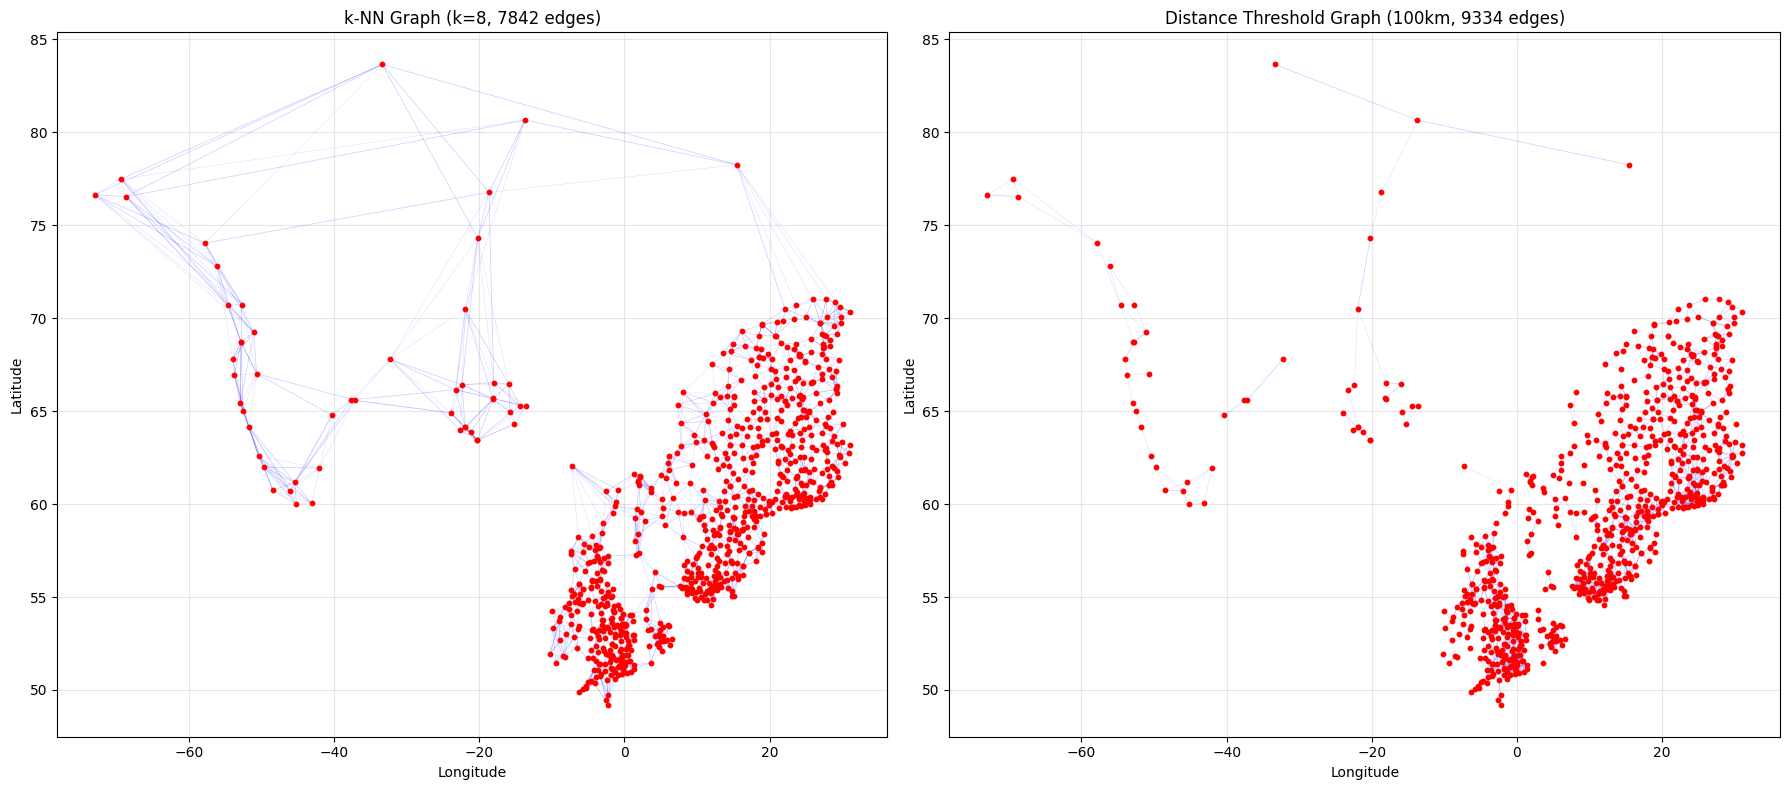

In [9]:
# Visualize graph on map
def plot_graph_on_map(edge_index, station_meta, title="Weather Station Graph", 
                      max_edges_to_plot=5000, ax=None):
    """
    Plot graph edges overlaid on station locations.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))
    
    # Get coordinates
    lons = station_meta['longitude'].values
    lats = station_meta['latitude'].values
    
    # Plot edges (subsample if too many)
    n_edges = edge_index.shape[1]
    if n_edges > max_edges_to_plot:
        indices = np.random.choice(n_edges, max_edges_to_plot, replace=False)
    else:
        indices = np.arange(n_edges)
    
    for idx in indices:
        i, j = edge_index[0, idx].item(), edge_index[1, idx].item()
        ax.plot([lons[i], lons[j]], [lats[i], lats[j]], 
                'b-', alpha=0.1, linewidth=0.5)
    
    # Plot stations
    ax.scatter(lons, lats, c='red', s=10, zorder=5)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    return ax

# Plot k-NN graph (k=8)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

plot_graph_on_map(knn_graphs[8]['edge_index'], station_meta, 
                  title=f"k-NN Graph (k=8, {knn_graphs[8]['edge_index'].shape[1]} edges)",
                  ax=axes[0])

plot_graph_on_map(dist_graphs[100]['edge_index'], station_meta,
                  title=f"Distance Threshold Graph (100km, {dist_graphs[100]['edge_index'].shape[1]} edges)",
                  ax=axes[1])

plt.tight_layout()
plt.show()

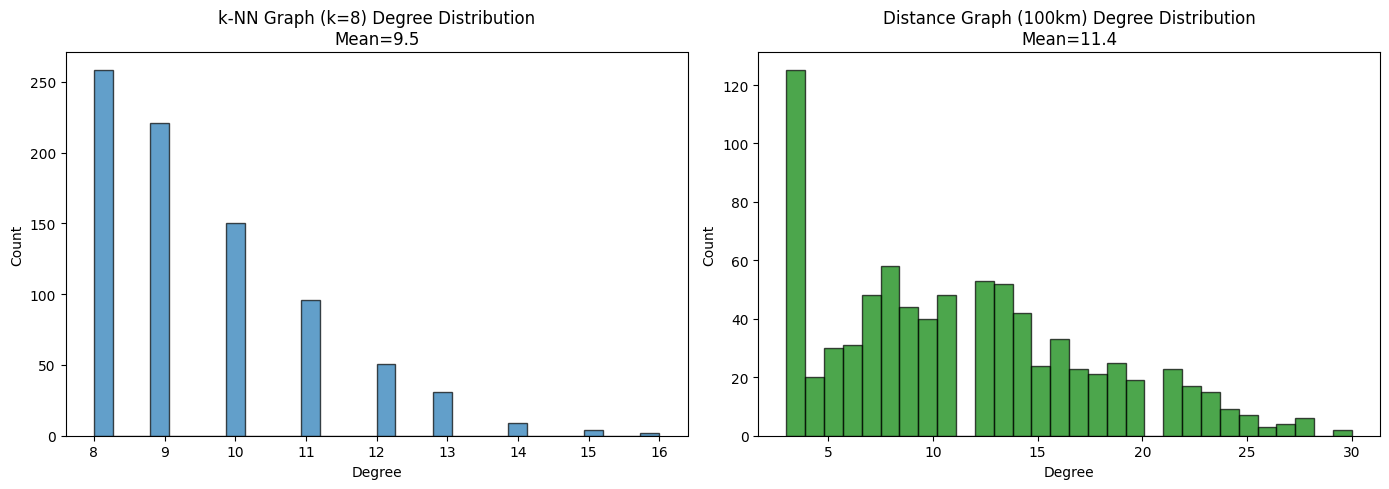

In [10]:
# Degree distribution
def get_degree_distribution(edge_index, n_nodes):
    """Compute degree of each node."""
    src = edge_index[0].numpy()
    degrees = np.bincount(src, minlength=n_nodes)
    return degrees

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# k-NN degree distribution
degrees_knn = get_degree_distribution(knn_graphs[8]['edge_index'], n_stations)
axes[0].hist(degrees_knn, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Count')
axes[0].set_title(f'k-NN Graph (k=8) Degree Distribution\nMean={degrees_knn.mean():.1f}')

# Distance threshold degree distribution
degrees_dist = get_degree_distribution(dist_graphs[100]['edge_index'], n_stations)
axes[1].hist(degrees_dist, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Distance Graph (100km) Degree Distribution\nMean={degrees_dist.mean():.1f}')

plt.tight_layout()
plt.show()

## 6. Create PyTorch Geometric Data Objects

In [11]:
# Select primary graph configuration
# Using k=8 k-NN as default (good balance of connectivity and sparsity)
PRIMARY_K = 8

print("=" * 60)
print("Creating PyTorch Geometric Data Objects")
print("=" * 60)

# Get graph components
edge_index = knn_graphs[PRIMARY_K]['edge_index']
edge_attr = knn_graphs[PRIMARY_K]['edge_attr']  # Raw distances
edge_weight = knn_graphs[PRIMARY_K]['edge_weight']  # Gaussian weights

# Create node features from station metadata
# Static features: latitude, longitude, elevation (normalized)
node_features = torch.tensor(
    station_meta[['latitude', 'longitude', 'elevation']].values,
    dtype=torch.float32
)

# Normalize node features
node_features_mean = node_features.mean(dim=0)
node_features_std = node_features.std(dim=0)
node_features_normalized = (node_features - node_features_mean) / (node_features_std + 1e-8)

print(f"\nNode features shape: {node_features_normalized.shape}")
print(f"Edge index shape: {edge_index.shape}")
print(f"Edge attr shape: {edge_attr.shape}")
print(f"Edge weight shape: {edge_weight.shape}")

Creating PyTorch Geometric Data Objects

Node features shape: torch.Size([822, 3])
Edge index shape: torch.Size([2, 7842])
Edge attr shape: torch.Size([7842, 1])
Edge weight shape: torch.Size([7842, 1])


In [12]:
# Create PyTorch Geometric Data object
graph_data = Data(
    x=node_features_normalized,  # Static node features (lat, lon, elev)
    edge_index=edge_index,
    edge_attr=edge_attr,  # Raw distances
    edge_weight=edge_weight,  # Gaussian weights
    num_nodes=n_stations
)

print("\nPyTorch Geometric Data object:")
print(graph_data)
print(f"\nIs undirected: {graph_data.is_undirected()}")
print(f"Has self-loops: {graph_data.has_self_loops()}")
print(f"Number of nodes: {graph_data.num_nodes}")
print(f"Number of edges: {graph_data.num_edges}")


PyTorch Geometric Data object:
Data(x=[822, 3], edge_index=[2, 7842], edge_attr=[7842, 1], edge_weight=[7842, 1], num_nodes=822)

Is undirected: True
Has self-loops: False
Number of nodes: 822
Number of edges: 7842


## 7. Save Graph Data

In [13]:
# Save graph data
print("=" * 60)
print("Saving Graph Data")
print("=" * 60)

# 1. Save primary graph (k-NN, k=8)
graph_file = GRAPH_DATA_DIR / f"weather_graph_knn_{PRIMARY_K}.pt"
torch.save(graph_data, graph_file)
print(f"✓ Saved primary graph: {graph_file}")

# 2. Save alternative graphs
for k, data in knn_graphs.items():
    alt_graph = Data(
        x=node_features_normalized,
        edge_index=data['edge_index'],
        edge_attr=data['edge_attr'],
        edge_weight=data['edge_weight'],
        num_nodes=n_stations
    )
    alt_file = GRAPH_DATA_DIR / f"weather_graph_knn_{k}.pt"
    torch.save(alt_graph, alt_file)
    print(f"✓ Saved k-NN graph (k={k}): {alt_file}")

# 3. Save distance threshold graph
dist_graph = Data(
    x=node_features_normalized,
    edge_index=dist_graphs[100]['edge_index'],
    edge_attr=dist_graphs[100]['edge_attr'],
    edge_weight=dist_graphs[100]['edge_weight'],
    num_nodes=n_stations
)
dist_file = GRAPH_DATA_DIR / "weather_graph_dist_100km.pt"
torch.save(dist_graph, dist_file)
print(f"✓ Saved distance graph (100km): {dist_file}")

Saving Graph Data
✓ Saved primary graph: C:\Users\Kata\Desktop\earth-sgnn\data\graphs\weather_graph_knn_8.pt
✓ Saved k-NN graph (k=4): C:\Users\Kata\Desktop\earth-sgnn\data\graphs\weather_graph_knn_4.pt
✓ Saved k-NN graph (k=8): C:\Users\Kata\Desktop\earth-sgnn\data\graphs\weather_graph_knn_8.pt
✓ Saved k-NN graph (k=12): C:\Users\Kata\Desktop\earth-sgnn\data\graphs\weather_graph_knn_12.pt
✓ Saved k-NN graph (k=16): C:\Users\Kata\Desktop\earth-sgnn\data\graphs\weather_graph_knn_16.pt
✓ Saved distance graph (100km): C:\Users\Kata\Desktop\earth-sgnn\data\graphs\weather_graph_dist_100km.pt


In [14]:
# 4. Save graph metadata
graph_metadata = {
    'n_nodes': n_stations,
    'node_feature_dim': 3,  # lat, lon, elevation
    'node_feature_names': ['latitude', 'longitude', 'elevation'],
    'node_features_mean': node_features_mean.tolist(),
    'node_features_std': node_features_std.tolist(),
    'primary_graph': {
        'type': 'knn',
        'k': PRIMARY_K,
        'n_edges': graph_data.num_edges,
        'avg_degree': graph_data.num_edges / n_stations,
        'edge_weight_method': 'gaussian',
        'edge_weight_sigma': 100
    },
    'knn_graphs': {
        k: {
            'n_edges': data['edge_index'].shape[1],
            'avg_degree': data['edge_index'].shape[1] / n_stations
        }
        for k, data in knn_graphs.items()
    },
    'distance_graphs': {
        f'{d}km': {
            'n_edges': data['edge_index'].shape[1],
            'avg_degree': data['edge_index'].shape[1] / n_stations
        }
        for d, data in dist_graphs.items()
    },
    'station_id_to_idx': station_id_to_idx,
    'created_at': datetime.now().isoformat()
}

metadata_file = GRAPH_DATA_DIR / "graph_metadata.json"
with open(metadata_file, 'w') as f:
    json.dump(graph_metadata, f, indent=2)
print(f"✓ Saved graph metadata: {metadata_file}")

✓ Saved graph metadata: C:\Users\Kata\Desktop\earth-sgnn\data\graphs\graph_metadata.json


In [15]:
# Summary
print("\n" + "=" * 60)
print("Graph Construction Complete!")
print("=" * 60)

print(f"\nPrimary Graph (k-NN, k={PRIMARY_K}):")
print(f"  Nodes: {n_stations}")
print(f"  Edges: {graph_data.num_edges}")
print(f"  Avg degree: {graph_data.num_edges / n_stations:.1f}")
print(f"  Node features: {graph_data.x.shape}")
print(f"  Edge features: {graph_data.edge_attr.shape}")

print(f"\nFiles saved to: {GRAPH_DATA_DIR}")
print(f"\nNext steps:")
print("1. Build baseline models (LSTM, simple spatial interpolation)")
print("2. Implement GNN model architecture")
print("3. Create data loaders for spatio-temporal sequences")


Graph Construction Complete!

Primary Graph (k-NN, k=8):
  Nodes: 822
  Edges: 7842
  Avg degree: 9.5
  Node features: torch.Size([822, 3])
  Edge features: torch.Size([7842, 1])

Files saved to: C:\Users\Kata\Desktop\earth-sgnn\data\graphs

Next steps:
1. Build baseline models (LSTM, simple spatial interpolation)
2. Implement GNN model architecture
3. Create data loaders for spatio-temporal sequences
